# Outline

# Import libraries and data

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve, plot_roc_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import LGBMRegressor

import os

In [2]:
# Unzip archive
!Unzip -o archive.zip

Archive:  archive.zip
  inflating: final.csv               
  inflating: race_wise_data/race_wise_data/1983/round_1.csv  
  inflating: race_wise_data/race_wise_data/1983/round_10.csv  
  inflating: race_wise_data/race_wise_data/1983/round_11.csv  
  inflating: race_wise_data/race_wise_data/1983/round_12.csv  
  inflating: race_wise_data/race_wise_data/1983/round_13.csv  
  inflating: race_wise_data/race_wise_data/1983/round_14.csv  
  inflating: race_wise_data/race_wise_data/1983/round_15.csv  
  inflating: race_wise_data/race_wise_data/1983/round_2.csv  
  inflating: race_wise_data/race_wise_data/1983/round_3.csv  
  inflating: race_wise_data/race_wise_data/1983/round_4.csv  
  inflating: race_wise_data/race_wise_data/1983/round_5.csv  
  inflating: race_wise_data/race_wise_data/1983/round_6.csv  
  inflating: race_wise_data/race_wise_data/1983/round_7.csv  
  inflating: race_wise_data/race_wise_data/1983/round_8.csv  
  inflating: race_wise_data/race_wise_data/1983/round_9.csv  
  in

## Merge raw datas

In [3]:
# Create empty DataFrame availbe for accpet values
# F1_data = pd.DataFrame()
# F1_data_year = pd.DataFrame()

In [4]:
# Utility Function
# def get_DataFrame_F1(dirname):
    #global F1_data
    #global F1_data_year
    #foldernames = os.listdir(dirname)
    #for folder in foldernames:
        #foldername = os.path.join(dirname, folder)
        #for file in foldername:
            #filenames = os.listdir(foldername)
            #for file in filenames:
                #filename = os.path.join(foldername, file)
                #F1_data_temp = pd.read_csv(filename)
                #F1_data_year = pd.concat([F1_data_year, F1_data_temp])
    #F1_data = pd.concat([F1_data, F1_data_year])
    #return F1_data

In [5]:
# Define dirname and create full DataFrame for EDA
# dirname = 'race_wise_data'
# get_DataFrame_F1(dirname)

## Load merged data

In [6]:
F1_data = pd.read_csv('/Users/escortkwon/Code/MiniProjects_Kaggle/Upvoted/10. F1 Race Data Prediction/final.csv')
F1_data

,Unnamed: 0,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,...,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,14,1983,1,jacarepagua,False,False,True,False,False,keke_rosberg,...,1,15,0,0,0,0,0,0,0.0,34
1,5,1983,1,jacarepagua,False,False,True,False,False,prost,...,2,6,0,0,0,0,0,0,0.2,28
2,3,1983,1,jacarepagua,False,False,True,False,False,tambay,...,3,4,0,0,0,0,0,0,0.3,33
3,0,1983,1,jacarepagua,False,False,True,False,False,piquet,...,4,1,0,0,0,0,0,0,0.6,30
4,6,1983,1,jacarepagua,False,False,True,False,False,warwick,...,5,7,0,0,0,0,0,0,0.7,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,15076,2021,11,hungaroring,False,False,False,True,False,raikkonen,...,13,10,1,0,15,2,0,8,2.2,41
14790,15072,2021,11,hungaroring,False,False,False,True,False,tsunoda,...,16,6,10,0,14,49,0,5,2.5,21
14791,15074,2021,11,hungaroring,False,False,False,True,False,russell,...,17,8,0,0,17,0,0,9,2.5,23
14792,15073,2021,11,hungaroring,False,False,False,True,False,latifi,...,18,7,0,0,19,0,0,9,2.6,26


## Dataset Overview

# Data Preprocessing

In [7]:
# Check features 'F1_data' contains
print('Features: ', F1_data.columns)
F1_data.head()

Features:  Index(['Unnamed: 0', 'season', 'round', 'circuit_id', 'weather_warm',
       'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy',
       'driver', 'nationality', 'constructor', 'grid', 'podium',
       'driver_points', 'driver_wins', 'driver_standings_pos',
       'constructor_points', 'constructor_wins', 'constructor_standings_pos',
       'qualifying_time', 'driver_age'],
      dtype='object')


,Unnamed: 0,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,...,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,14,1983,1,jacarepagua,False,False,True,False,False,keke_rosberg,...,1,15,0,0,0,0,0,0,0.0,34
1,5,1983,1,jacarepagua,False,False,True,False,False,prost,...,2,6,0,0,0,0,0,0,0.2,28
2,3,1983,1,jacarepagua,False,False,True,False,False,tambay,...,3,4,0,0,0,0,0,0,0.3,33
3,0,1983,1,jacarepagua,False,False,True,False,False,piquet,...,4,1,0,0,0,0,0,0,0.6,30
4,6,1983,1,jacarepagua,False,False,True,False,False,warwick,...,5,7,0,0,0,0,0,0,0.7,28


In [8]:
# Check whether 'crimes' contains any Null or NaN values
F1_data.isnull().sum()

Unnamed: 0                   0
season                       0
round                        0
circuit_id                   0
weather_warm                 0
weather_cold                 0
weather_dry                  0
weather_wet                  0
weather_cloudy               0
driver                       0
nationality                  0
constructor                  0
grid                         0
podium                       0
driver_points                0
driver_wins                  0
driver_standings_pos         0
constructor_points           0
constructor_wins             0
constructor_standings_pos    0
qualifying_time              0
driver_age                   0
dtype: int64

In [9]:
# Additional arranging 'F1_data'
F1_data.sort_values(by=['season', 'round'], ascending=True, inplace=True)
F1_data.drop('Unnamed: 0', axis=1, inplace=True)
F1_data.reset_index(drop=True, inplace=True)
F1_data

,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,nationality,...,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,1983,1,jacarepagua,False,False,True,False,False,keke_rosberg,Finnish,...,1,15,0,0,0,0,0,0,0.0,34
1,1983,1,jacarepagua,False,False,True,False,False,prost,French,...,2,6,0,0,0,0,0,0,0.2,28
2,1983,1,jacarepagua,False,False,True,False,False,tambay,French,...,3,4,0,0,0,0,0,0,0.3,33
3,1983,1,jacarepagua,False,False,True,False,False,piquet,Brazilian,...,4,1,0,0,0,0,0,0,0.6,30
4,1983,1,jacarepagua,False,False,True,False,False,warwick,British,...,5,7,0,0,0,0,0,0,0.7,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,2021,11,hungaroring,False,False,False,True,False,raikkonen,Finnish,...,13,10,1,0,15,2,0,8,2.2,41
14790,2021,11,hungaroring,False,False,False,True,False,tsunoda,Japanese,...,16,6,10,0,14,49,0,5,2.5,21
14791,2021,11,hungaroring,False,False,False,True,False,russell,British,...,17,8,0,0,17,0,0,9,2.5,23
14792,2021,11,hungaroring,False,False,False,True,False,latifi,Canadian,...,18,7,0,0,19,0,0,9,2.6,26


In [10]:
# Create another DataFrame for training
F1_data_train = F1_data.copy()
F1_data_train.drop(['season', 'round', 'circuit_id', 'driver', 'nationality', 'constructor'], axis=1, inplace=True)

weathers = ['weather_warm', 'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy']
for weather in weathers:
    F1_data_train[weather] = F1_data_train[weather].apply(lambda x : 1 if x == True else 0)

F1_data_train

,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,0,0,1,0,0,1,15,0,0,0,0,0,0,0.0,34
1,0,0,1,0,0,2,6,0,0,0,0,0,0,0.2,28
2,0,0,1,0,0,3,4,0,0,0,0,0,0,0.3,33
3,0,0,1,0,0,4,1,0,0,0,0,0,0,0.6,30
4,0,0,1,0,0,5,7,0,0,0,0,0,0,0.7,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,0,0,0,1,0,13,10,1,0,15,2,0,8,2.2,41
14790,0,0,0,1,0,16,6,10,0,14,49,0,5,2.5,21
14791,0,0,0,1,0,17,8,0,0,17,0,0,9,2.5,23
14792,0,0,0,1,0,18,7,0,0,19,0,0,9,2.6,26


## Summary
The dataset has already been preprocessed, so there're nothing left to do.  
But, it contains 21 features which are relatively more than any other datasets.


# Decomposition

<AxesSubplot:title={'center':'Corrleation Heatmap of F1_data'}>

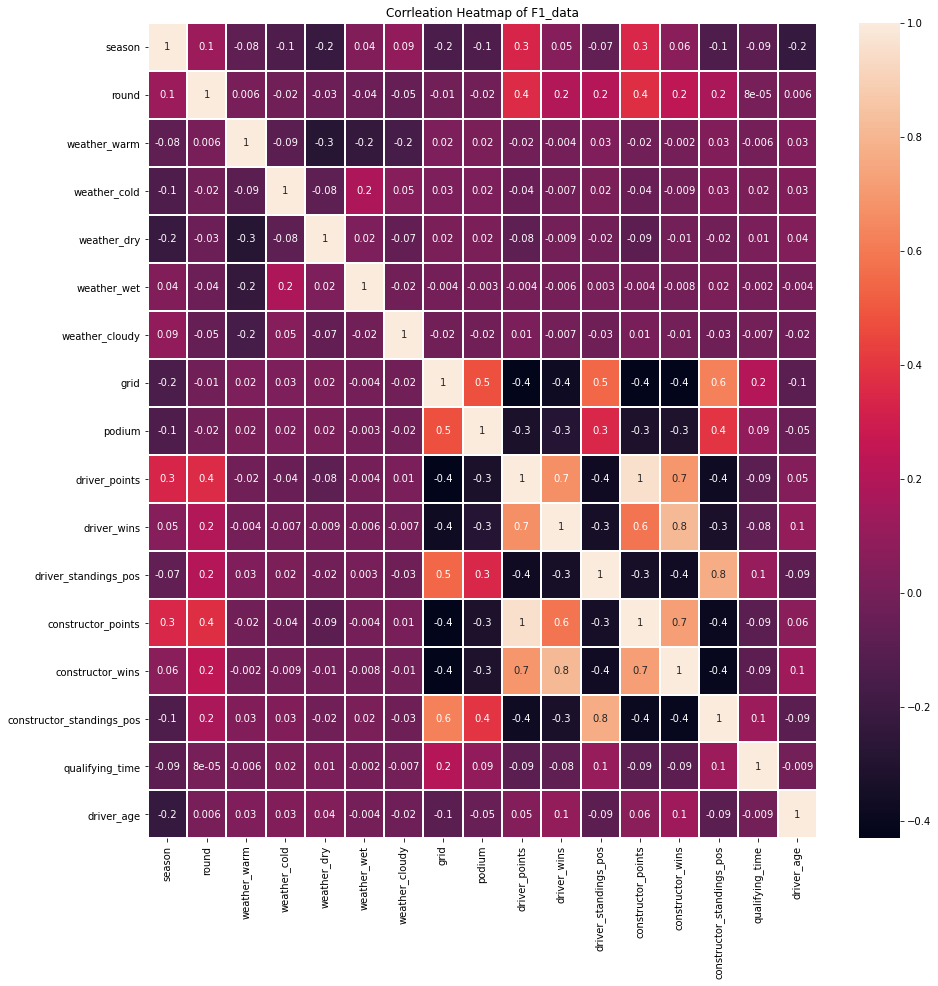

In [11]:
# Check corrleation of 'F1_data'
plt.figure(figsize=(15, 15))
plt.title('Corrleation Heatmap of F1_data')
sns.heatmap(F1_data.corr(), annot=True, fmt='.1g', linewidths=.3)

## Description
As you can see heatmap above, featrues from 'grid' to 'constructor_standing_pos' are heavily related with dataset.  
Therefore, using PCA, we are gonna process decomposition

In [12]:
features_dec = ['grid', 'podium', 'driver_points', 'driver_standings_pos', 'constructor_points', 'constructor_wins', 'constructor_standings_pos']
F1_data_scaled = F1_data.copy()

scaler = StandardScaler()
F1_data_scaled = scaler.fit_transform(F1_data[features_dec])
pca = PCA(n_components=2)
pca.fit(F1_data_scaled)
print('Variability by PCA Components: ', pca.explained_variance_ratio_)

Variability by PCA Components:  [0.5568089  0.18606925]


## Description
We can explain explain the variance of 7 features with 2 PCA components  
The total variance is about 73% and the first axis was the highest with 55%

In [13]:
# Set X, y as features and label
F1_data_scaled = F1_data_train.copy()

X_features = F1_data_scaled.drop('driver_wins', axis=1, inplace=False)
y_label = F1_data_scaled['driver_wins']
print('Shape of X_features: {0} / Shape of y_label: {1}'.format(X_features.shape, y_label.shape))

Shape of X_features: (14794, 14) / Shape of y_label: (14794,)


In [14]:
# Evaluate accuracy score without PCA
rf_clf = RandomForestClassifier(n_estimators=300, random_state=11)
scores = cross_val_score(rf_clf, X_features, y_label, scoring='accuracy', cv=3)

print('Accuracy by each fold: ', scores)
print('Average Accuracy: {0:.4f}'.format(np.mean(scores)))

Accuracy by each fold:  [0.90004055 0.89393632 0.87304806]
Average Accuracy: 0.8890


In [15]:
# Evaluate accuracy score with PCA
pca = PCA(n_components=7)
df_pca = pca.fit_transform(X_features)
scores_pca = cross_val_score(rf_clf, df_pca, y_label, scoring='accuracy', cv=3)

print('Accuracy by each fold PCA converted: ', scores_pca)
print('Average Accuracy PCA converted: {0:.4f}'.format(np.mean(scores_pca)))

Accuracy by each fold PCA converted:  [0.86699108 0.8679781  0.75583046]
Average Accuracy PCA converted: 0.8303


## Summary
The number of columns was decreased from 14 to 7, so the decreased rate is 50%  
But, the accuracy score was decreased from 88.99% to 83.44%, which means 6% decreased  

# Visualization

## Distribution of Weather

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

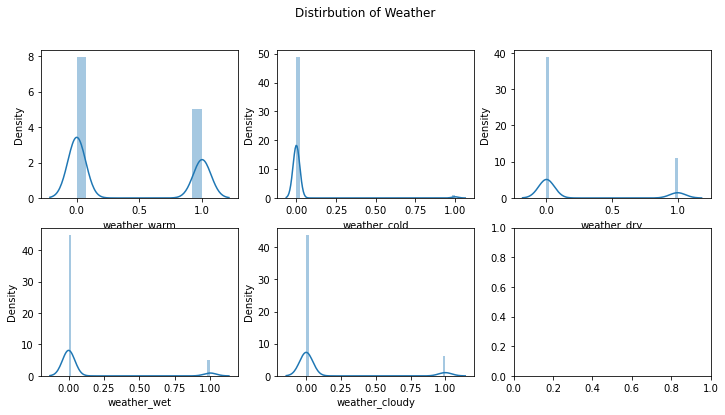

In [16]:
# Extract data for plotting distribution
F1_data_weather = F1_data.iloc[:, [3, 4, 5, 6, 7]]

# Check distribution of each features
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, feature in enumerate(F1_data_weather.columns):
    row = int(i/3)
    col = i%3
    sns.distplot(F1_data_weather.iloc[:, i], ax=axs[row][col])

plt.suptitle('Distirbution of Weather by Density Plot')
plt.tight_layout

In [17]:
# Create another dataframes for pie charts
F1_data_weather_binary = F1_data_train.iloc[:, range(0, 5)]
F1_weather_warm = pd.value_counts(F1_data_weather_binary['weather_warm'])
F1_weather_cold = pd.value_counts(F1_data_weather_binary['weather_cold'])
F1_weather_dry = pd.value_counts(F1_data_weather_binary['weather_dry'])
F1_weather_wet = pd.value_counts(F1_data_weather_binary['weather_wet'])
F1_weather_cloudy = pd.value_counts(F1_data_weather_binary['weather_cloudy'])

Text(0.5, 0.98, 'Distribution of Weather by Pie Chart')

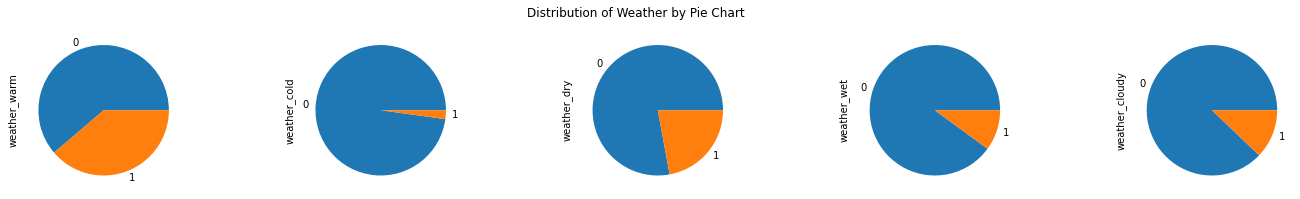

In [18]:
# Plot pie charts
fig, axs = plt.subplots(ncols=5, figsize=(24, 3))

F1_weather_warm.plot.pie(ax=axs[0])
F1_weather_cold.plot.pie(ax=axs[1])
F1_weather_dry.plot.pie(ax=axs[2])
F1_weather_wet.plot.pie(ax=axs[3])
F1_weather_cloudy.plot.pie(ax=axs[4])

plt.suptitle('Distribution of Weather by Pie Chart')

### Description
That plot shows the distribution of weather.  
Generally, it was warm and moderate

## Distribution of Nationality

In [19]:
# Create DataFrame for Pie Chart
F1_data_nation = pd.DataFrame(data=F1_data['nationality'].value_counts())
F1_data_nation.reset_index(inplace=True)
F1_data_nation.rename({'index' : 'nationality', 'nationality' : 'count'}, axis=1, inplace=True)
F1_data_nation.sort_values(by='count', ascending=False, inplace=True)
F1_data_nation.head()

,nationality,count
0,British,2172
1,Italian,2137
2,German,1786
3,French,1590
4,Brazilian,1457
5,Finnish,1003
6,Spanish,672
7,Japanese,547
8,Australian,444
9,Austrian,431


In [20]:
# Encode features
le = LabelEncoder()

le.fit(F1_data_nation['nationality'])
F1_data_nation['nationality_le'] = le.transform(F1_data_nation['nationality'])
F1_data_nation.head()

,nationality,count,nationality_le
0,British,2172,6
1,Italian,2137,20
2,German,1786,15
3,French,1590,14
4,Brazilian,1457,5
5,Finnish,1003,13
6,Spanish,672,29
7,Japanese,547,21
8,Australian,444,2
9,Austrian,431,3


Text(0.5, 1.0, 'Distribution of Nationality')

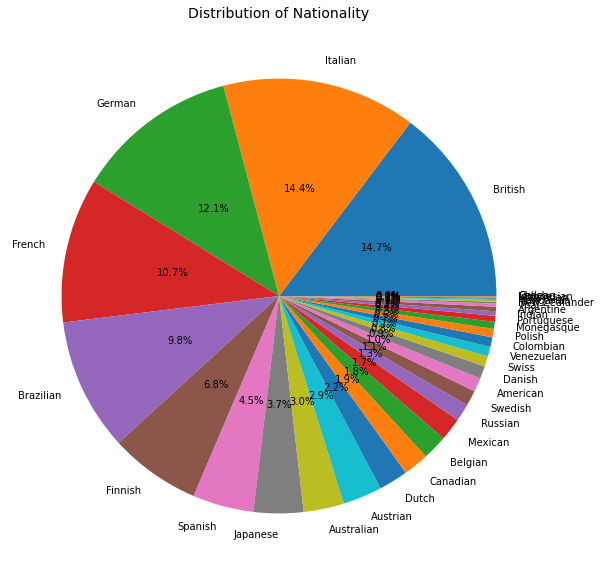

In [21]:
# Pie Chart
pie, ax = plt.subplots(figsize=[10, 10])
labels = F1_data_nation['nationality']
plt.pie(F1_data_nation['count'], autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Distribution of Nationality", fontsize=14)

Text(0.5, 1.0, 'Distribution of Nationality [Top 10]')

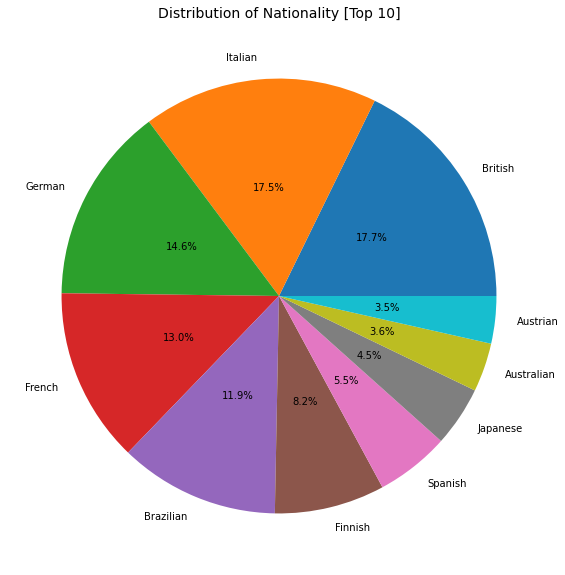

In [22]:
# Pie Chart
pie, ax = plt.subplots(figsize=[10, 10])
labels = F1_data_nation.iloc[0:10, 0]
plt.pie(F1_data_nation.iloc[0:10, 1], autopct="%.1f%%", labels=labels, pctdistance=0.5)
plt.title("Distribution of Nationality [Top 10]", fontsize=14)

### Description
Usually, countries in Europe were superior to other countries.

## Distribution of Age

<AxesSubplot:title={'center':'Distribution of Age'}, xlabel='driver_age', ylabel='Density'>

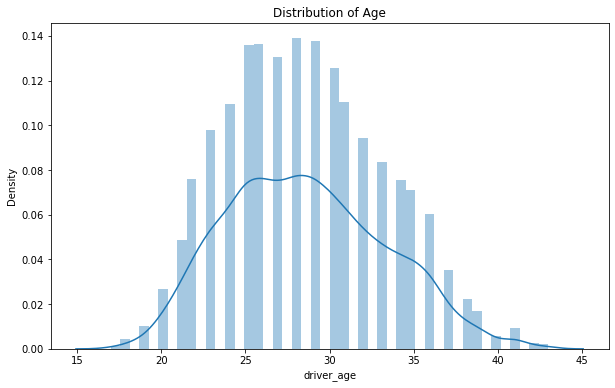

In [23]:
# Plot density plot
plt.figure(figsize=(10, 6))
plt.title('Distribution of Age')
sns.distplot(F1_data['driver_age'])

### Description
The distribution of age of drivers were much similiar as Normal Distribution which is compatible for training.

# Create Datasets

In [24]:
# Scaling
for feature in F1_data_train.columns:
    scaler = StandardScaler()
    scaler = scaler.fit(np.array(F1_data_train[feature]).reshape(-1, 1))
    F1_data_train[feature] = scaler.transform(np.array(F1_data_train[feature]).reshape(-1, 1))

F1_data_train

,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.605849,0.458616,-0.473911,-0.30957,-1.390191,-0.490791,-0.377619,-1.527113,-0.319232,1.144411
1,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.456622,-0.871469,-0.473911,-0.30957,-1.390191,-0.490791,-0.377619,-1.527113,-0.294232,-0.123912
2,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.307394,-1.167044,-0.473911,-0.30957,-1.390191,-0.490791,-0.377619,-1.527113,-0.281732,0.933024
3,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.158166,-1.610406,-0.473911,-0.30957,-1.390191,-0.490791,-0.377619,-1.527113,-0.244232,0.298863
4,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.008938,-0.723682,-0.473911,-0.30957,-1.390191,-0.490791,-0.377619,-1.527113,-0.231732,-0.123912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,-0.795205,-0.148927,-0.532583,2.990352,-0.371601,0.184886,-0.280320,-0.450145,-0.30957,0.565219,-0.466288,-0.377619,0.559315,-0.044232,2.624121
14790,-0.795205,-0.148927,-0.532583,2.990352,-0.371601,0.632569,-0.871469,-0.236253,-0.30957,0.434859,0.109542,-0.377619,-0.223095,-0.006732,-1.603622
14791,-0.795205,-0.148927,-0.532583,2.990352,-0.371601,0.781797,-0.575895,-0.473911,-0.30957,0.825941,-0.490791,-0.377619,0.820119,-0.006732,-1.180847
14792,-0.795205,-0.148927,-0.532583,2.990352,-0.371601,0.931025,-0.723682,-0.473911,-0.30957,1.086662,-0.490791,-0.377619,0.820119,0.005768,-0.546686


In [25]:
# Set X, y for features and label
X = F1_data_train.drop('driver_wins', axis=1, inplace=False)
y = F1_data_train['driver_wins'].astype(int)

In [26]:
# Split datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (11835, 14)
Shape of X_test:  (2959, 14)
Shape of y_train:  (11835,)
Shape of y_test:  (2959,)


# Classification

## MultiClass Classification

In [48]:
# Utility Function
def get_clf_eval_binary(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovr', average='macro')
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [28]:
# Utility Function
def get_clf_eval_multiclass(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='macro')
    recall = recall_score(y_test, pred, average='macro')
    f1 = f1_score(y_test, pred, average='macro')
    #roc_auc = roc_auc_score(y_test, pred_proba, multi_class='ovo', average='macro')
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))

In [50]:
# Plot Function
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # Extarct ndarray of threshold and ndarray of precision, recall by itself
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    # Set X axis for threshold values, Y axis for precision, recall and create plot
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # Scaling threshold values of 0.1 units on X axis
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # Set labels of X axis, y axis, legend and grid
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()

In [52]:
# Plot Function
def roc_curve_plot(y_test, pred_proba_c1):
    # Return values of FPR, TPR by thresholds
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # Plot ROC curve
    plt.plot(fprs, tprs, label='ROC')
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # Scaling threshold values of 0.1 units on X axis(FPR)
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    # Set label of X, Y axis
    plt.xlabel('FPR(1 - Sensitivity)')
    plt.ylabel('TPR(Recall)')
    plt.legend()

    plt.show()

In [29]:
# Create Estimator CLass
lr_clf = LogisticRegression()

# Fitting
lr_clf.fit(X_train, y_train)

# Prediction
lr_pred = lr_clf.predict(X_test)

# Pred_Proba
lr_pred_proba = lr_clf.predict_proba(X_test)

# Evaluation
get_clf_eval_multiclass(y_test, lr_pred, lr_pred_proba)

Confusion Matrix
[[2680   18    0    0    0    0    0    0    0    0    0]
 [  45   26    4    3    1    0    0    0    0    0    0]
 [   9   34    8    9    1    0    0    0    0    0    0]
 [   0   10   12   39    4    0    0    2    0    0    0]
 [   0    0    0   24    2    1    0    2    0    0    0]
 [   0    0    0    7    0    0    0    0    1    0    0]
 [   0    0    0    2    0    1    0    3    0    0    0]
 [   0    0    0    0    0    2    1    2    0    0    0]
 [   0    0    0    1    0    0    0    2    0    1    0]
 [   0    0    0    1    0    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    0    0    0    0]]
Accuracy: 0.9317, Precision: 0.2242, Recall 0.2277, F1: 0.2138


## Binary Classification

In [46]:
# For binary classification, we should make 'driver_wins' as binary values(0, 1)
binarizer = Binarizer(threshold=F1_data_train['driver_wins'].median())
F1_data_train['driver_wins'] = binarizer.fit_transform(np.array(F1_data_train['driver_wins']).reshape(-1, 1))
F1_data_train

,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,podium,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,qualifying_time,driver_age
0,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.605849,0.458616,-0.473911,0,-1.390191,-0.490791,-0.377619,-1.527113,-0.319232,1.144411
1,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.456622,-0.871469,-0.473911,0,-1.390191,-0.490791,-0.377619,-1.527113,-0.294232,-0.123912
2,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.307394,-1.167044,-0.473911,0,-1.390191,-0.490791,-0.377619,-1.527113,-0.281732,0.933024
3,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.158166,-1.610406,-0.473911,0,-1.390191,-0.490791,-0.377619,-1.527113,-0.244232,0.298863
4,-0.795205,-0.148927,1.877643,-0.334409,-0.371601,-1.008938,-0.723682,-0.473911,0,-1.390191,-0.490791,-0.377619,-1.527113,-0.231732,-0.123912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14789,-0.795205,-0.148927,-0.532583,2.990352,-0.371601,0.184886,-0.280320,-0.450145,0,0.565219,-0.466288,-0.377619,0.559315,-0.044232,2.624121
14790,-0.795205,-0.148927,-0.532583,2.990352,-0.371601,0.632569,-0.871469,-0.236253,0,0.434859,0.109542,-0.377619,-0.223095,-0.006732,-1.603622
14791,-0.795205,-0.148927,-0.532583,2.990352,-0.371601,0.781797,-0.575895,-0.473911,0,0.825941,-0.490791,-0.377619,0.820119,-0.006732,-1.180847
14792,-0.795205,-0.148927,-0.532583,2.990352,-0.371601,0.931025,-0.723682,-0.473911,0,1.086662,-0.490791,-0.377619,0.820119,0.005768,-0.546686


In [45]:
# Set X, y for features and label
X = F1_data_train.drop('driver_wins', axis=1, inplace=False)
y = F1_data_train['driver_wins'].astype(int)

In [47]:
# Split datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

print('Shape of X_train: ', X_train.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of y_test: ', y_test.shape)

Shape of X_train:  (11835, 14)
Shape of X_test:  (2959, 14)
Shape of y_train:  (11835,)
Shape of y_test:  (2959,)


In [49]:
# Process fitting, prediction and evalution by Logistic Regression
# Create Estimator CLass
dt_clf = DecisionTreeClassifier()
lr_clf = LogisticRegression()
rf_clf = RandomForestClassifier()

# Fitting
dt_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

# Prediction
dt_pred = dt_clf.predict(X_test)
lr_pred = lr_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)

# Pred_Proba
dt_pred_proba = dt_clf.predict_proba(X_test)[:, 1]
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
rf_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

# Evaluation
get_clf_eval_binary(y_test, dt_pred, dt_pred_proba)
get_clf_eval_binary(y_test, lr_pred, lr_pred_proba)
get_clf_eval_binary(y_test, rf_pred, rf_pred_proba)

Confusion Matrix
[[2476   37]
 [  48  398]]
Accuracy: 0.9713, Precision: 0.9480, Recall 0.9388, F1: 0.9433, AUC:0.9388
Confusion Matrix
[[2467   46]
 [ 107  339]]
Accuracy: 0.9483, Precision: 0.9195, Recall 0.8709, F1: 0.8929, AUC:0.9793
Confusion Matrix
[[2464   49]
 [  26  420]]
Accuracy: 0.9747, Precision: 0.9425, Recall 0.9611, F1: 0.9515, AUC:0.9959


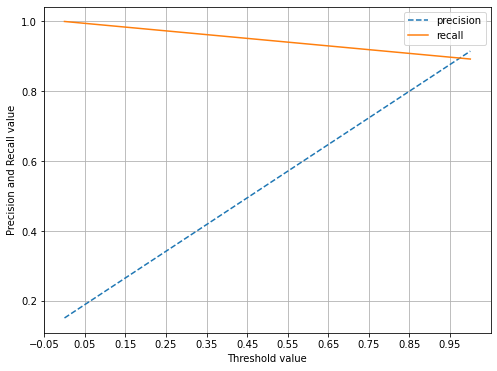

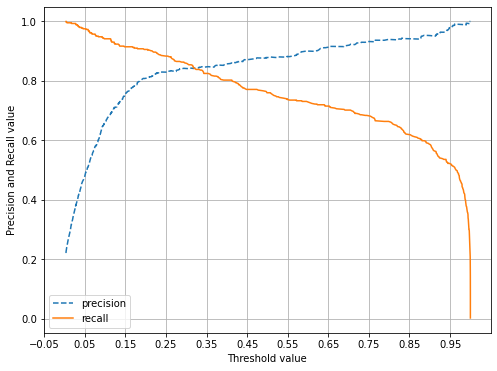

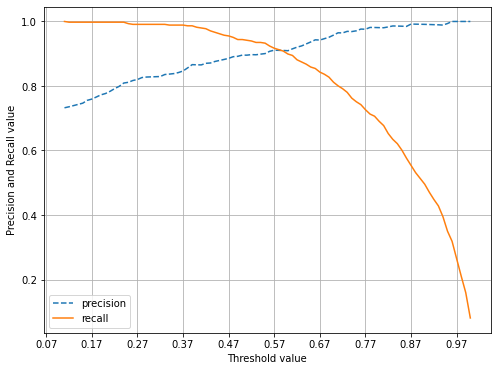

In [51]:
# DecisionTreeClassifier
precision_recall_curve_plot(y_test, dt_pred_proba)
# LogisitcRegression
precision_recall_curve_plot(y_test, lr_pred_proba)
# RandomForestClassifier
precision_recall_curve_plot(y_test, rf_pred_proba)

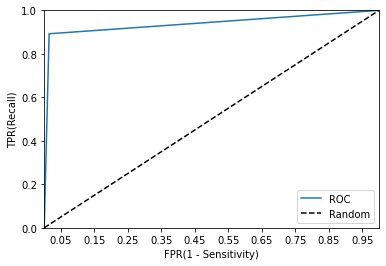

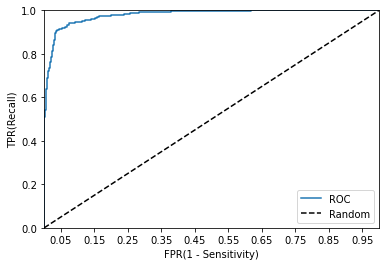

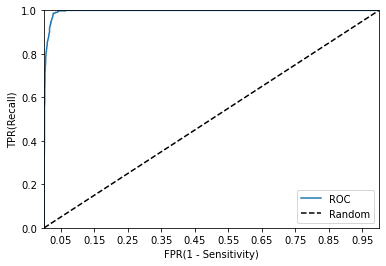

In [53]:
# Plot ROC-AUC Curve
# DecisionTreeClassifier
roc_curve_plot(y_test, dt_pred_proba)
# LogisticRegression
roc_curve_plot(y_test, lr_pred_proba)
# RandomForestClassifier
roc_curve_plot(y_test, rf_pred_proba)